**Rhodium Hydrogenation of Enamides TSFF Parameterized by a new Hybrid Optimizer**

Rh Hyd Enamides TSFF as a test case for the use of a new Hybrid Particle Swarm-Differential Evolution Optimization Algorithm (hybrid_optimizer) developed by Mikaela Farrugia (github: @mmfarrugia) under Olaf Wiest & Paul Helquist.

These are all being run with the pbest localization as convergence criterion.
Note: Score distributions are incorrect due to funky mm3.fld vs mm3.hybrid.fld issue which is now fixed but untested/unrun

In [1]:
import os
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import sys
from matplotlib import animation, rc
from IPython.display import HTML, Image
import seaborn
import pickle
import pandas as pd
from numpy import copy
from scipy import stats
import itertools

seaborn.set_theme(style="whitegrid")

#src_dir = os.path.abspath("/home/mmfarrugia/repos/q2mm/q2mm")
sys.path.append("/home/mfarrugi/repos/q2mm/rh-hybrid/schrodinger.ve/lib/python3.8/site-packages/q2mm-0.0.0-py3.8.egg")

#from hybrid_optimizer import PSO_GA
import q2mm.hybrid_optimizer as hybrid_optimizer
from q2mm.hybrid_optimizer import PSO_DE
from tools.plotters import plot_cost_history, plot_contour, plot_surface, plot_summary, Mesher, Designer




All are done with 8 workers, 10 particles/TSFF candidates, with 0.001 convergence criteria, run for loop cycles of 50 iter maximum with 3 technical replicates run for each case. Further information regarding the settings, files, and parameters used in the optimizations can be found in their respective directories under the README.txt file.

All hyperparameters are derived from literature **INCLUDE REFS** and use the TIGHT_OPT_CONFIG.

In [2]:
num_particles = 10
cycle_iter_length = 50
num_workers = 8
convergence_criteria = 0.001
num_tech_replicates = 3
num_params = 31

**Start: FUERZA estimated FCs + Donoghue charges**

Original Score: 1.36078

In [3]:
# Gather data on starting point

fuerza_score = 1.36077746
score_cols = ["Label", "Weight", "Reference", "Calculated", "Score", "FF"]
skiprows=[0, 1, 106390, 106391, 106392, 106393, 106394, 106395, 106396, 106397, 106398, 106399, 106400, 106401]

qf_scores = pd.read_csv('/home/mfarrugi/repos/q2mm/rh-hybrid/q_fuerza/rh_qf_start.txt', skiprows=skiprows, delim_whitespace=True, names=score_cols).assign(FF=fuerza_score)
# /opt_qstatic_start_hybrid_eig
bond_cols = ["param_type", "atom1", "atom2", "Equilibrium Value", "Force Constant", "Dipole Moment", "FF"]
angle_cols = ["param_type", "atom1", "atom2", "atom3", "Equilibrium Value", "Force Constant", "FF"]

bond_rows = np.arange(1859, 1867)
angle_rows = np.arange(1867, 1889)

#bond_start = pd.read_csv('/home/mfarrugi/repos/q2mm/rh-hybrid/q_fuerza/mm3.old.fld', skiprows=lambda x: x not in bond_rows, delim_whitespace=True, names=bond_cols).assign(FF=0)
#angle_start = pd.read_csv('/home/mfarrugi/repos/q2mm/rh-hybrid/q_fuerza/mm3.old.fld', skiprows=lambda x: x not in angle_rows, delim_whitespace=True, names=angle_cols).assign(FF=0)

bond_start = pd.read_csv('/home/mfarrugi/repos/q2mm/rh-hybrid/q_fuerza/mm3.fld', skiprows=lambda x: x not in bond_rows, delim_whitespace=True, names=bond_cols).assign(FF=fuerza_score)
angle_start = pd.read_csv('/home/mfarrugi/repos/q2mm/rh-hybrid/q_fuerza/mm3.fld', skiprows=lambda x: x not in angle_rows, delim_whitespace=True, names=angle_cols).assign(FF=fuerza_score)




TIGHT SPREAD!!

PSO ONLY

In [4]:
base_directory = '/home/mfarrugi/repos/q2mm/rh-hybrid/q_fuerza/pso_only'
directory_list = ['1', '2', '3']

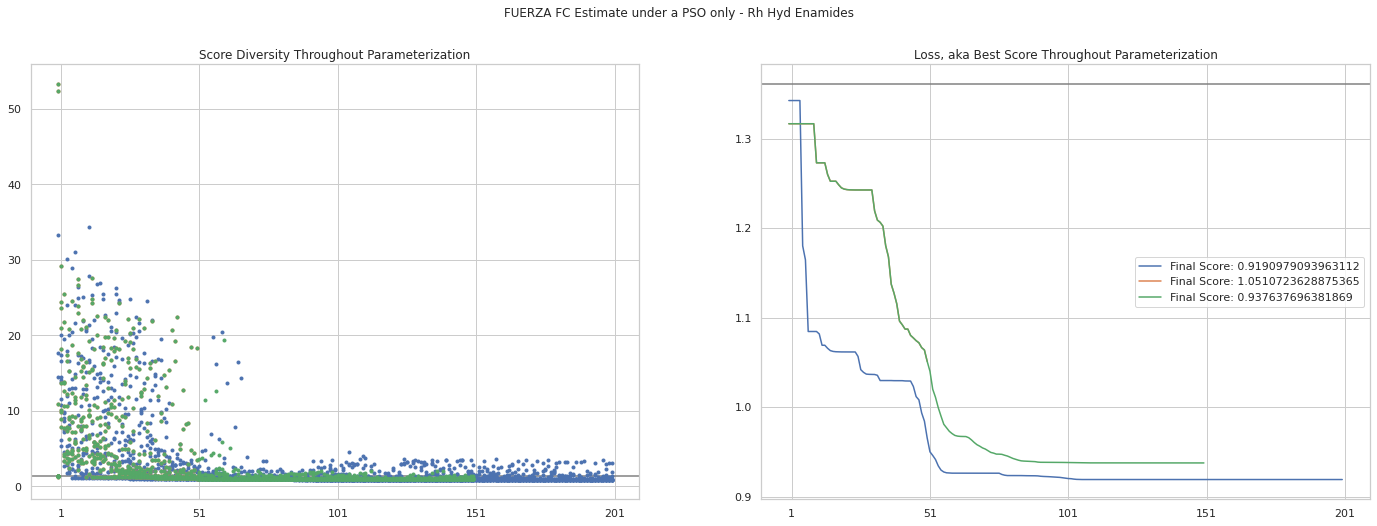

In [5]:
%matplotlib inline
# PSO ONLY
fig, ax = plt.subplots(1, 2, figsize=(24, 8))
fig.suptitle('FUERZA FC Estimate under a PSO only - Rh Hyd Enamides')
ax[0].set_title('Score Diversity Throughout Parameterization')
ax[1].set_title('Loss, aka Best Score Throughout Parameterization')

ax[0].axhline(y=fuerza_score, color='gray')
ax[1].axhline(y=fuerza_score, color='gray')

final_scores = []

for directory in directory_list:

    swarm_history_file = open(os.path.join(base_directory, directory, 'hybrid_opt_history.bin'), 'rb')
    swarm_history = pickle.load(swarm_history_file)
    swarm_history_file.close()
    num_iters = len(swarm_history['Y'])
    num_ffs = len(swarm_history['Y'][0])
    assert num_ffs == num_particles
    color = next(ax[0]._get_lines.prop_cycler)['color']
    Y_history = pd.DataFrame(np.array(swarm_history['Y']).reshape((num_iters, num_ffs)))
    ax[0].plot(Y_history.index, Y_history.values, '.', color=color)
    loss = Y_history.min(axis=1).cummin()
    loss.plot(kind='line', ax=ax[1], color=color, label='Final Score: '+str(loss.iloc[-1]))
    final_scores.append(loss.iloc[-1])

ax[1].legend()

ax[0].xaxis.set_ticks(np.arange(1, ax[0].get_xlim()[1], cycle_iter_length))
ax[1].xaxis.set_ticks(np.arange(1, ax[0].get_xlim()[1], cycle_iter_length))

plt.show()

In [7]:
%matplotlib inline
# Plot Scores

score_cols = ["Label", "Weight", "Reference", "Calculated", "Score", "FF"]
runs = []
for directory, score in zip(directory_list, final_scores):
    runs.append(pd.read_csv(os.path.join(base_directory, directory, 'rh_qf_pso_end.txt'), skiprows=[0, 1, 106390, 106391, 106392, 106393, 106394, 106395, 106396, 106397, 106398, 106399, 106400, 106401], delim_whitespace=True, names=score_cols).assign(FF=score))


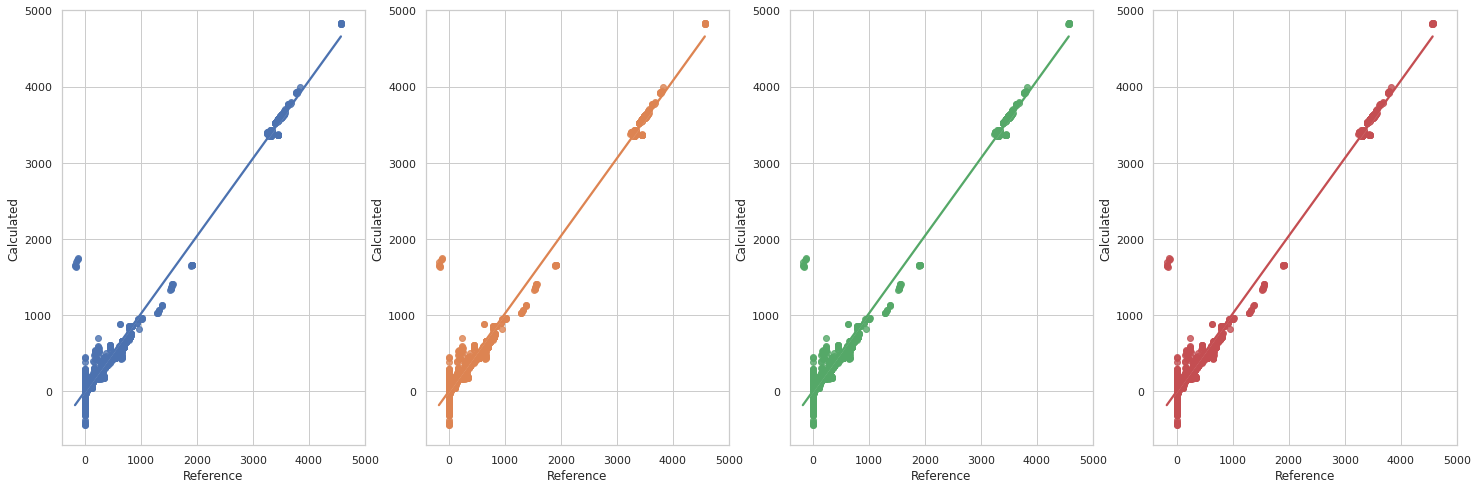

In [8]:
fig, ax = plt.subplots(1, len(runs)+1, figsize=(25, 8))
palette = itertools.cycle(seaborn.color_palette())

color = next(palette)
seaborn.regplot(data=qf_scores, x=score_cols[2], y=score_cols[3], label='FF', fit_reg=True, ax=ax[0], color=color)
ax[0].set_ylim(top=5000)
ax[0].set_xlim(xmax = 5000)

for i, run in enumerate(runs):
    color = next(palette)
    seaborn.regplot(data=run, x=score_cols[2], y=score_cols[3], label='FF', fit_reg=True, ax=ax[i+1], color=color)

    ax[i+1].set_ylim(top=5000)
    ax[i+1].set_xlim(xmax = 5000)

plt.show()

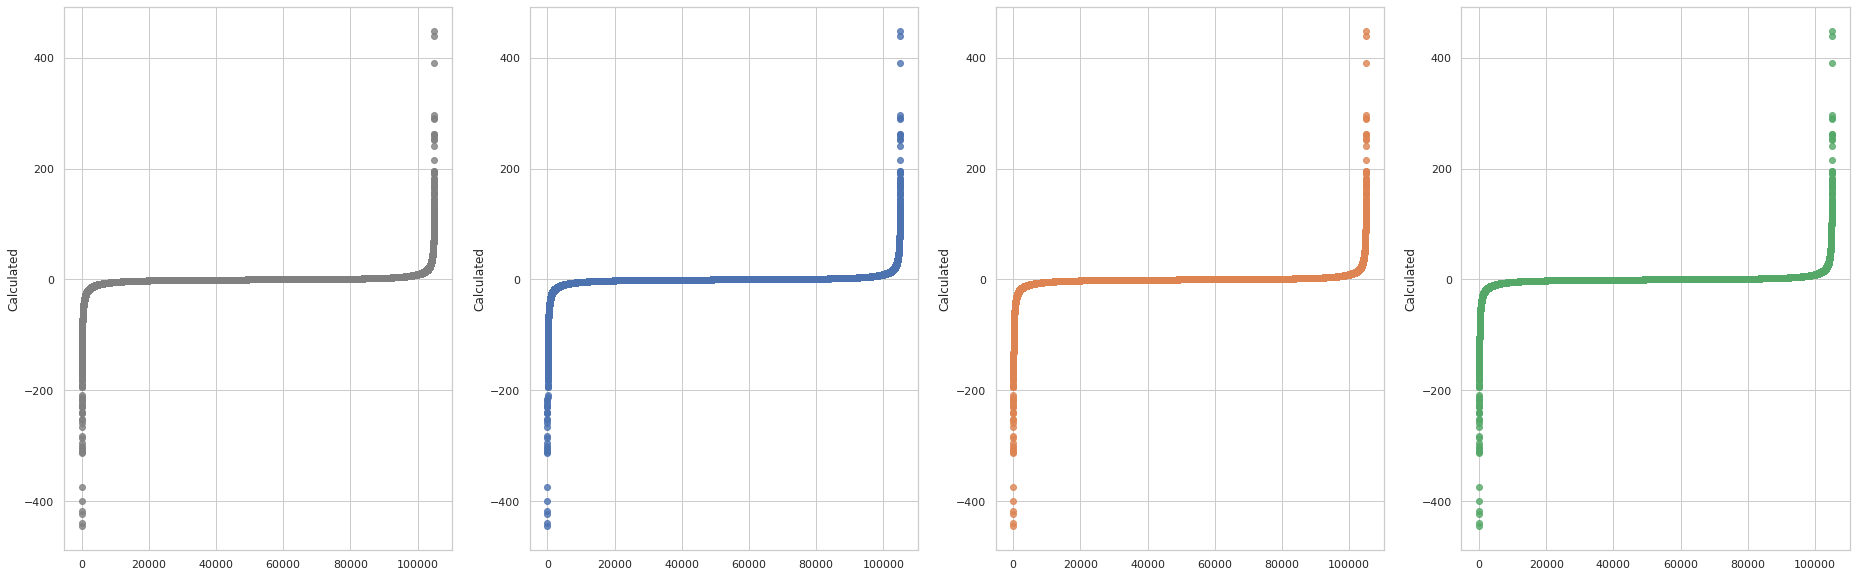

In [9]:
# Plot only off diagonal elements


fig, ax = plt.subplots(1, 4, figsize=(32, 10))
palette = itertools.cycle(seaborn.color_palette())

off_diag_start = qf_scores.loc[qf_scores['Reference'] == 0.0000]
off_diag_start = off_diag_start.sort_values(by='Calculated', ignore_index=True)
seaborn.regplot(data=off_diag_start, x=off_diag_start.index, label='FF', y=score_cols[3], fit_reg=False, ax=ax[0], color='gray')

for i, run in enumerate(runs):
    off_diag = run.loc[run['Reference'] == 0.0000]
    off_diag = off_diag.sort_values(by='Calculated', ignore_index=True)

    color = next(palette)
    seaborn.regplot(data=off_diag, x=off_diag.index, label='FF', y=score_cols[3], fit_reg=False, ax=ax[i+1], color=color)

plt.show()


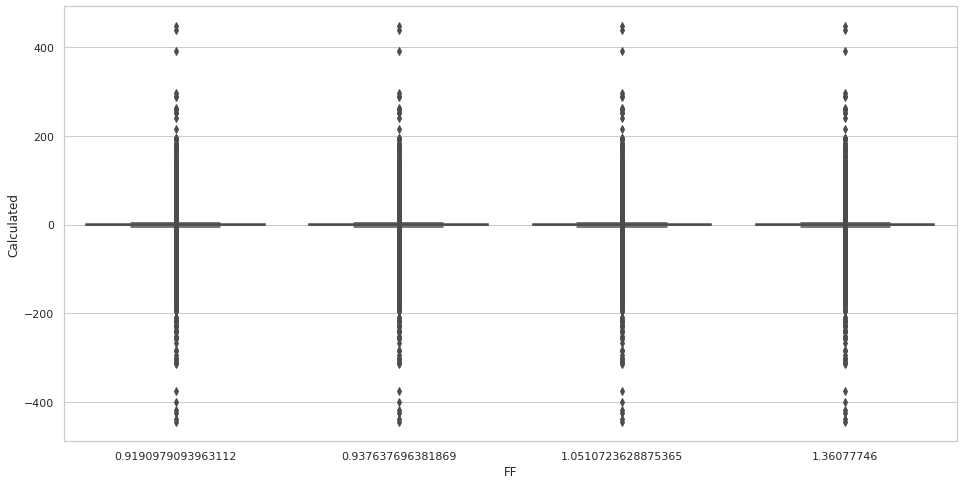

In [10]:
# VIOLIN Plot only off diagonal elements


fig, ax = plt.subplots(1, 1, figsize=(16, 8))
off_diag_merged = pd.concat([run.loc[run['Reference'] == 0.0000] for run in runs])
off_diag_merged = pd.concat([off_diag_merged, off_diag_start])
off_diag_merged = off_diag_merged.sort_values(by='Calculated')

seaborn.boxplot(data=off_diag_merged, x='FF', y=score_cols[3])

plt.show()

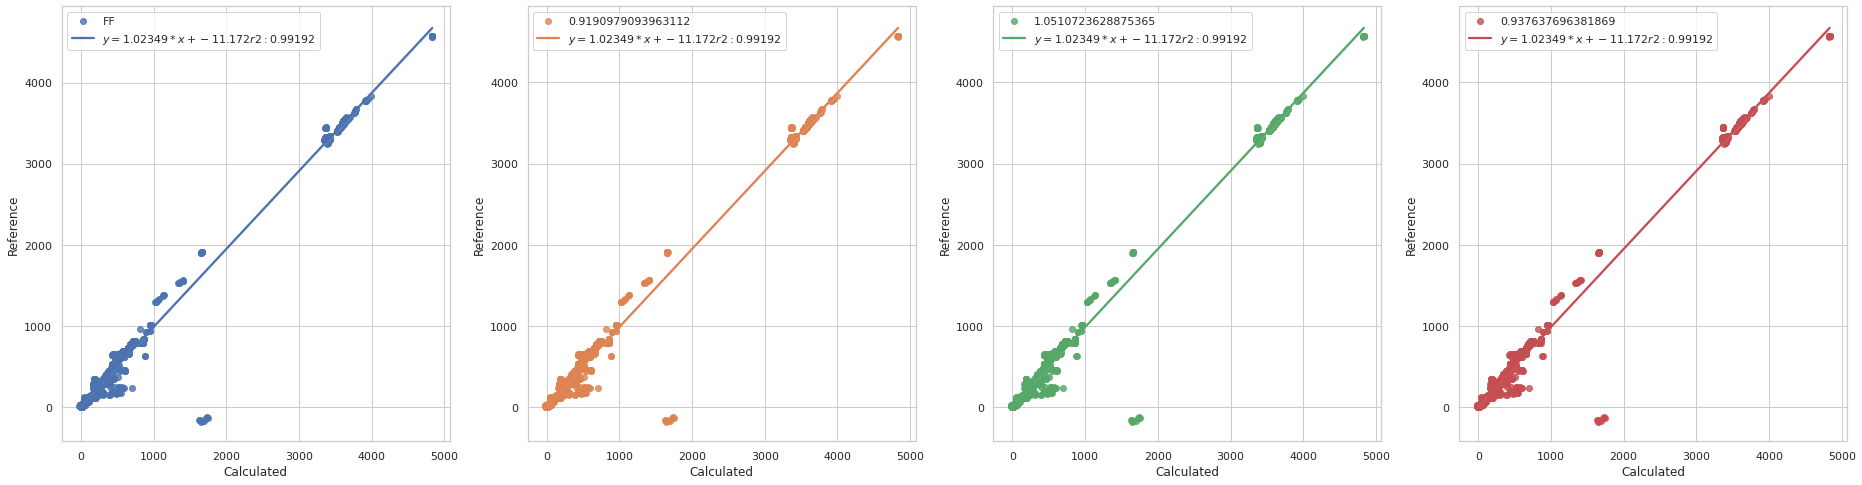

In [19]:
# Plot Diagonal Elements with a linear fit

fig, ax = plt.subplots(1, 4, figsize=(32,8))
palette = itertools.cycle(seaborn.color_palette())

diag = qf_scores.loc[qf_scores['Reference'] != 0.0000]
slope, intercept, r2, pv, se = stats.linregress(diag['Reference'], diag['Calculated'])

seaborn.regplot(data=diag, x='Calculated', y='Reference', color=next(palette), label='FF', line_kws={'label':'$y=%3.7s*x+%3.7s   r2:%3.7s$'%(slope, intercept, r2)}, ax=ax[0])
ax[0].legend()

for i, run in enumerate(runs):
    diag = run.loc[run['Reference'] != 0.0000]
    slope, intercept, r2, pv, se = stats.linregress(diag['Reference'], diag['Calculated'])
    
    seaborn.regplot(data=diag, x='Calculated', y='Reference', color=next(palette), label=final_scores[i], line_kws={'label':'$y=%3.7s*x+%3.7s   r2:%3.7s$'%(slope, intercept, r2)}, ax=ax[i+1])

    ax[i+1].legend()

In [20]:
%matplotlib inline
# Plot FCs

bonds = []
angles = []

for directory, score in zip(directory_list, final_scores):
    bonds.append(pd.read_csv(os.path.join(base_directory, directory, 'rh_qf_pso_end.fld'), skiprows=lambda x: x not in bond_rows, delim_whitespace=True, names=bond_cols).assign(FF=score))
    angles.append(pd.read_csv(os.path.join(base_directory, directory, 'rh_qf_pso_end.fld'), skiprows=lambda x: x not in angle_rows, delim_whitespace=True, names=angle_cols).assign(FF=score))


['[1 2]', '[2 3]', '[2 3]', '[2 4]', '[2 6]', '[2 9]', '[4 5]', '[5 6]']


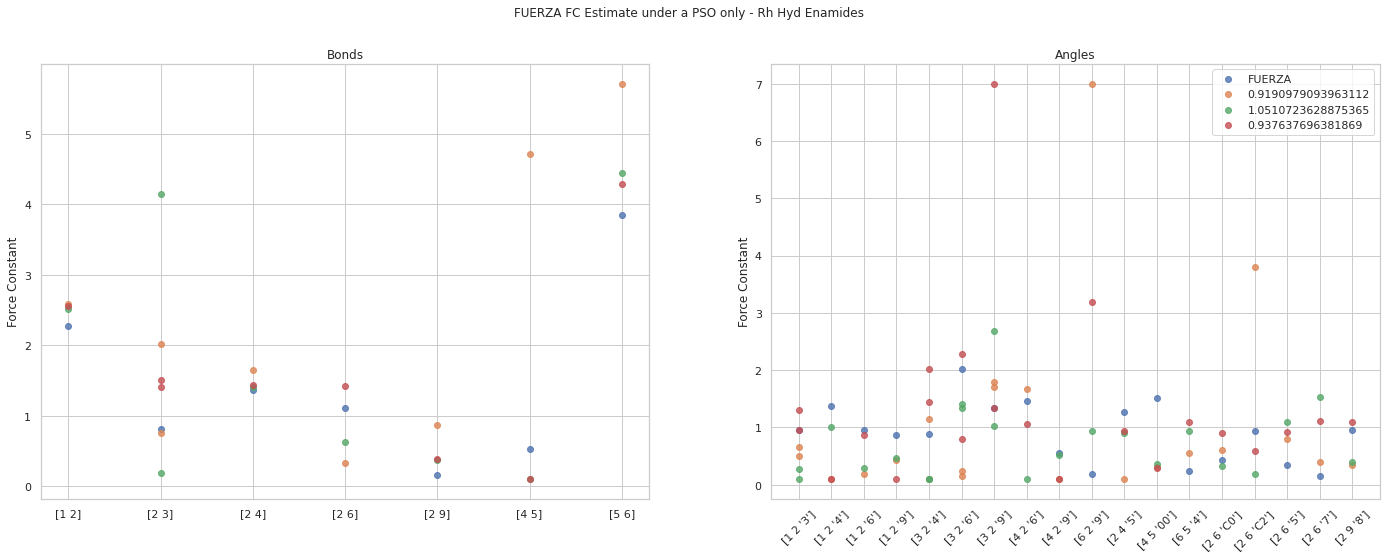

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(24, 8))
fig.suptitle('FUERZA FC Estimate under a PSO only - Rh Hyd Enamides')
ax[0].set_title('Bonds')
ax[1].set_title('Angles')

palette = itertools.cycle(seaborn.color_palette())

color = next(palette)
seaborn.regplot(data=bond_start, label='FUERZA', x = bond_start.index, y="Force Constant", fit_reg=False, ax=ax[0], color=color)
seaborn.regplot(data=angle_start, label='FUERZA', x = angle_start.index, y="Force Constant", fit_reg=False, ax=ax[1], color=color)
bond_labels = bonds[i][['atom1', 'atom2']].values
bond_labels = [str(bl) for bl in bond_labels]
angles_labels = angles[i][['atom1', 'atom2', 'atom3']].values
angles_labels = [str(bl) for bl in angles_labels]
print(bond_labels)
for i in range(len(directory_list)):
    color = next(palette)
    seaborn.regplot(data=bonds[i], label=final_scores[i], x = bond_labels, y="Force Constant", fit_reg=False, ax=ax[0], color=color)
    seaborn.regplot(data=angles[i], label=final_scores[i], x = angles_labels, y="Force Constant", fit_reg=False, ax=ax[1], color=color)

plt.xticks(rotation=45)
ax[1].legend()
plt.show()

DE ONLY

In [ ]:
base_directory = '/home/mfarrugi/repos/q2mm/rh-hybrid/q_fuerza/de_only'
directory_list = ['1']#, '2', '3']

In [ ]:
%matplotlib inline
# DE ONLY
fig, ax = plt.subplots(1, 2, figsize=(24, 8))
fig.suptitle('FUERZA FC Estimate under a DE only - Rh Hyd Enamides')
ax[0].set_title('Score Diversity Throughout Parameterization')
ax[1].set_title('Loss, aka Best Score Throughout Parameterization')

ax[0].axhline(y=fuerza_score, color='gray')
ax[1].axhline(y=fuerza_score, color='gray')

for directory in directory_list:

    swarm_history_file = open(os.path.join(base_directory, directory, 'hybrid_opt_history.bin'), 'rb')
    swarm_history = pickle.load(swarm_history_file)
    swarm_history_file.close()
    num_iters = len(swarm_history['Y'])
    num_ffs = len(swarm_history['Y'][0])
    assert num_ffs == num_particles
    color = next(ax[0]._get_lines.prop_cycler)['color']
    Y_history = pd.DataFrame(np.array(swarm_history['Y']).reshape((num_iters, num_ffs)))
    ax[0].plot(Y_history.index, Y_history.values, '.', color=color)
    loss = Y_history.min(axis=1).cummin()
    loss.plot(kind='line', ax=ax[1], color=color, label='Final Score: '+str(loss.iloc[-1]))

ax[1].legend()
ax[0].set_ylim(top=10)
ax[0].xaxis.set_ticks(np.arange(1, ax[0].get_xlim()[1], cycle_iter_length))
ax[1].xaxis.set_ticks(np.arange(1, ax[0].get_xlim()[1], cycle_iter_length))

plt.show()

In [ ]:
%matplotlib inline
# Plot Scores

score_cols = ["Label", "Weight", "Reference", "Calculated", "Score", "FF"]
runs = []
for directory in directory_list:
    runs.append(pd.read_csv(os.path.join(base_directory, directory, 'rh_qf_pso_end.txt'), skiprows=[0, 1, 106390, 106391, 106392, 106393, 106394, 106395, 106396, 106397, 106398, 106399, 106400, 106401], delim_whitespace=True, names=score_cols).assign(FF=directory))


In [ ]:
fig, ax = plt.subplots(1, len(runs)+1, figsize=(25, 8))
palette = itertools.cycle(seaborn.color_palette())

#TODO plot against starting point
color = next(palette)
seaborn.regplot(data=qf_scores, x=score_cols[2], y=score_cols[3], fit_reg=True, ax=ax[0], color=color)
ax[0].set_ylim(top=5000)
ax[0].set_xlim(xmax = 5000)

for i, run in enumerate(runs):
    color = next(palette)
    seaborn.regplot(data=run, x=score_cols[2], y=score_cols[3], fit_reg=True, ax=ax[i+1], color=color)

    ax[i+1].set_ylim(top=5000)
    ax[i+1].set_xlim(xmax = 5000)

plt.show()

In [ ]:
# Plot only off diagonal elements


fig, ax = plt.subplots(1, 4, figsize=(32, 10))
palette = itertools.cycle(seaborn.color_palette())

off_diag_start = qf_scores.loc[qf_scores['Reference'] == 0.0000]
off_diag_start = off_diag_start.sort_values(by='Calculated', ignore_index=True)
seaborn.regplot(data=off_diag_start, x=off_diag_start.index, y=score_cols[3], fit_reg=False, ax=ax[0], color='gray')

for i, run in enumerate(runs):
    off_diag = run.loc[run['Reference'] == 0.0000]
    off_diag = off_diag.sort_values(by='Calculated', ignore_index=True)

    color = next(palette)
    seaborn.regplot(data=off_diag, x=off_diag.index, y=score_cols[3], fit_reg=False, ax=ax[i+1], color=color)

plt.show()


In [ ]:
# VIOLIN Plot only off diagonal elements


fig, ax = plt.subplots(1, 1, figsize=(16, 8))
off_diag_merged = pd.concat([run.loc[run['Reference'] == 0.0000] for run in runs])
off_diag_merged = pd.concat([off_diag_merged, off_diag_start])
off_diag_merged = off_diag_merged.sort_values(by='Calculated')

seaborn.boxplot(data=off_diag_merged, x='FF', y=score_cols[3])

plt.show()

In [ ]:
# Plot Diagonal Elements with a linear fit

fig, ax = plt.subplots(1, 4, figsize=(32,8))
palette = itertools.cycle(seaborn.color_palette())

diag = qf_scores.loc[qf_scores['Reference'] != 0.0000]
slope, intercept, r2, pv, se = stats.linregress(diag['Reference'], diag['Calculated'])

seaborn.regplot(data=diag, x='Calculated', y='Reference', color=next(palette), line_kws={'label':'$y=%3.7s*x+%3.7s   r2:%3.7s$'%(slope, intercept, r2)}, ax=ax[0])
ax[0].legend()

for i, run in enumerate(runs):
    diag = run.loc[run['Reference'] != 0.0000]
    slope, intercept, r2, pv, se = stats.linregress(diag['Reference'], diag['Calculated'])
    
    seaborn.regplot(data=diag, x='Calculated', y='Reference', color=next(palette), line_kws={'label':'$y=%3.7s*x+%3.7s   r2:%3.7s$'%(slope, intercept, r2)}, ax=ax[i+1])

    ax[i+1].legend()

In [ ]:
%matplotlib inline
# Plot FCs

bonds = []
angles = []

for directory in directory_list:
    bonds.append(pd.read_csv(os.path.join(base_directory, directory, 'rh_qf_pso_end.fld'), skiprows=lambda x: x not in bond_rows, delim_whitespace=True, names=bond_cols).assign(FF=directory))
    angles.append(pd.read_csv(os.path.join(base_directory, directory, 'rh_qf_pso_end.fld'), skiprows=lambda x: x not in angle_rows, delim_whitespace=True, names=angle_cols).assign(FF=directory))


In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(24, 8))
fig.suptitle('FUERZA FC Estimate under a PSO only - Rh Hyd Enamides')
ax[0].set_title('Bonds')
ax[1].set_title('Angles')

palette = itertools.cycle(seaborn.color_palette())

for i in range(len(directory_list)):
    color = next(palette)
    seaborn.regplot(data=bonds[i], x = bonds[i].index, y="Force Constant", fit_reg=False, ax=ax[0], color=color)
    seaborn.regplot(data=angles[i], x = angles[i].index, y="Force Constant", fit_reg=False, ax=ax[1], color=color)


plt.show()

HYBRID NO TAPER

In [ ]:
base_directory = '/home/mfarrugi/repos/q2mm/rh-hybrid/q_fuerza/de_throughout'
directory_list = ['1', '2', '3']

In [ ]:
%matplotlib inline
# HYBRID NO TAPER
fig, ax = plt.subplots(1, 2, figsize=(24, 8))
fig.suptitle('FUERZA FC Estimate under a DE-throughout HO - Rh Hyd Enamides')
ax[0].set_title('Score Diversity Throughout Parameterization')
ax[1].set_title('Loss, aka Best Score Throughout Parameterization')

ax[0].axhline(y=fuerza_score, color='gray')
ax[1].axhline(y=fuerza_score, color='gray')

for directory in directory_list:

    swarm_history_file = open(os.path.join(base_directory, directory, 'hybrid_opt_history.bin'), 'rb')
    swarm_history = pickle.load(swarm_history_file)
    swarm_history_file.close()
    num_iters = len(swarm_history['Y'])
    num_ffs = len(swarm_history['Y'][0])
    assert num_ffs == num_particles
    color = next(ax[0]._get_lines.prop_cycler)['color']
    Y_history = pd.DataFrame(np.array(swarm_history['Y']).reshape((num_iters, num_ffs)))
    ax[0].plot(Y_history.index, Y_history.values, '.', color=color)
    loss = Y_history.min(axis=1).cummin()
    loss.plot(kind='line', ax=ax[1], color=color, label='Final Score: '+str(loss.iloc[-1]))

ax[1].legend()

ax[0].xaxis.set_ticks(np.arange(1, ax[0].get_xlim()[1], cycle_iter_length))
ax[1].xaxis.set_ticks(np.arange(1, ax[0].get_xlim()[1], cycle_iter_length))

plt.show()

In [ ]:
%matplotlib inline
# Plot Scores

score_cols = ["Label", "Weight", "Reference", "Calculated", "Score", "FF"]
runs = []
for directory in directory_list:
    runs.append(pd.read_csv(os.path.join(base_directory, directory, 'rh_qf_pso_end.txt'), skiprows=[0, 1, 106390, 106391, 106392, 106393, 106394, 106395, 106396, 106397, 106398, 106399, 106400, 106401], delim_whitespace=True, names=score_cols).assign(FF=directory))


In [ ]:
fig, ax = plt.subplots(1, len(runs)+1, figsize=(25, 8))
palette = itertools.cycle(seaborn.color_palette())

#TODO plot against starting point
color = next(palette)
seaborn.regplot(data=qf_scores, x=score_cols[2], y=score_cols[3], fit_reg=True, ax=ax[0], color=color)
ax[0].set_ylim(top=5000)
ax[0].set_xlim(xmax = 5000)

for i, run in enumerate(runs):
    color = next(palette)
    seaborn.regplot(data=run, x=score_cols[2], y=score_cols[3], fit_reg=True, ax=ax[i+1], color=color)

    ax[i+1].set_ylim(top=5000)
    ax[i+1].set_xlim(xmax = 5000)

plt.show()

In [ ]:
# Plot only off diagonal elements


fig, ax = plt.subplots(1, 4, figsize=(32, 10))
palette = itertools.cycle(seaborn.color_palette())

off_diag_start = qf_scores.loc[qf_scores['Reference'] == 0.0000]
off_diag_start = off_diag_start.sort_values(by='Calculated', ignore_index=True)
seaborn.regplot(data=off_diag_start, x=off_diag_start.index, y=score_cols[3], fit_reg=False, ax=ax[0], color='gray')

for i, run in enumerate(runs):
    off_diag = run.loc[run['Reference'] == 0.0000]
    off_diag = off_diag.sort_values(by='Calculated', ignore_index=True)

    color = next(palette)
    seaborn.regplot(data=off_diag, x=off_diag.index, y=score_cols[3], fit_reg=False, ax=ax[i+1], color=color)

plt.show()


In [ ]:
# VIOLIN Plot only off diagonal elements


fig, ax = plt.subplots(1, 1, figsize=(16, 8))
off_diag_merged = pd.concat([run.loc[run['Reference'] == 0.0000] for run in runs])
off_diag_merged = pd.concat([off_diag_merged, off_diag_start])
off_diag_merged = off_diag_merged.sort_values(by='Calculated')

seaborn.boxplot(data=off_diag_merged, x='FF', y=score_cols[3])

plt.show()

In [ ]:
# Plot Diagonal Elements with a linear fit

fig, ax = plt.subplots(1, 4, figsize=(32,8))
palette = itertools.cycle(seaborn.color_palette())

diag = qf_scores.loc[qf_scores['Reference'] != 0.0000]
slope, intercept, r2, pv, se = stats.linregress(diag['Reference'], diag['Calculated'])

seaborn.regplot(data=diag, x='Calculated', y='Reference', color=next(palette), line_kws={'label':'$y=%3.7s*x+%3.7s   r2:%3.7s$'%(slope, intercept, r2)}, ax=ax[0])
ax[0].legend()

for i, run in enumerate(runs):
    diag = run.loc[run['Reference'] != 0.0000]
    slope, intercept, r2, pv, se = stats.linregress(diag['Reference'], diag['Calculated'])
    
    seaborn.regplot(data=diag, x='Calculated', y='Reference', color=next(palette), line_kws={'label':'$y=%3.7s*x+%3.7s   r2:%3.7s$'%(slope, intercept, r2)}, ax=ax[i+1])

    ax[i+1].legend()

In [ ]:
%matplotlib inline
# Plot FCs

bonds = []
angles = []

for directory in directory_list:
    bonds.append(pd.read_csv(os.path.join(base_directory, directory, 'rh_qf_pso_end.fld'), skiprows=lambda x: x not in bond_rows, delim_whitespace=True, names=bond_cols).assign(FF=directory))
    angles.append(pd.read_csv(os.path.join(base_directory, directory, 'rh_qf_pso_end.fld'), skiprows=lambda x: x not in angle_rows, delim_whitespace=True, names=angle_cols).assign(FF=directory))


In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(24, 8))
fig.suptitle('FUERZA FC Estimate under a PSO only - Rh Hyd Enamides')
ax[0].set_title('Bonds')
ax[1].set_title('Angles')

palette = itertools.cycle(seaborn.color_palette())

for i in range(len(directory_list)):
    color = next(palette)
    seaborn.regplot(data=bonds[i], x = bonds[i].index, y="Force Constant", fit_reg=False, ax=ax[0], color=color)
    seaborn.regplot(data=angles[i], x = angles[i].index, y="Force Constant", fit_reg=False, ax=ax[1], color=color)


plt.show()

HYBRID TAPER

In [ ]:
base_directory = '/home/mfarrugi/repos/q2mm/rh-hybrid/q_fuerza/freq_de_tapered'
directory_list = ['1', '2', '3']

In [ ]:
%matplotlib inline
# HYBRID NO TAPER
fig, ax = plt.subplots(1, 2, figsize=(24, 8))
fig.suptitle('FUERZA FC Estimate under a DE-freq-tapered HO - Rh Hyd Enamides')
ax[0].set_title('Score Diversity Throughout Parameterization')
ax[1].set_title('Loss, aka Best Score Throughout Parameterization')

ax[0].axhline(y=fuerza_score, color='gray')
ax[1].axhline(y=fuerza_score, color='gray')

for directory in directory_list:

    swarm_history_file = open(os.path.join(base_directory, directory, 'hybrid_opt_history.bin'), 'rb')
    swarm_history = pickle.load(swarm_history_file)
    swarm_history_file.close()
    num_iters = len(swarm_history['Y'])
    num_ffs = len(swarm_history['Y'][0])
    assert num_ffs == num_particles
    color = next(ax[0]._get_lines.prop_cycler)['color']
    Y_history = pd.DataFrame(np.array(swarm_history['Y']).reshape((num_iters, num_ffs)))
    ax[0].plot(Y_history.index, Y_history.values, '.', color=color)
    loss = Y_history.min(axis=1).cummin()
    loss.plot(kind='line', ax=ax[1], color=color, label='Final Score: '+str(loss.iloc[-1]))

ax[1].legend()

ax[0].xaxis.set_ticks(np.arange(1, ax[0].get_xlim()[1], cycle_iter_length))
ax[1].xaxis.set_ticks(np.arange(1, ax[0].get_xlim()[1], cycle_iter_length))

plt.show()

In [ ]:
%matplotlib inline
# Plot Scores

score_cols = ["Label", "Weight", "Reference", "Calculated", "Score", "FF"]
runs = []
for directory in directory_list:
    runs.append(pd.read_csv(os.path.join(base_directory, directory, 'rh_qf_pso_end.txt'), skiprows=[0, 1, 106390, 106391, 106392, 106393, 106394, 106395, 106396, 106397, 106398, 106399, 106400, 106401], delim_whitespace=True, names=score_cols).assign(FF=directory))


In [ ]:
fig, ax = plt.subplots(1, len(runs)+1, figsize=(25, 8))
palette = itertools.cycle(seaborn.color_palette())

#TODO plot against starting point
color = next(palette)
seaborn.regplot(data=qf_scores, x=score_cols[2], y=score_cols[3], fit_reg=True, ax=ax[0], color=color)
ax[0].set_ylim(top=5000)
ax[0].set_xlim(xmax = 5000)

for i, run in enumerate(runs):
    color = next(palette)
    seaborn.regplot(data=run, x=score_cols[2], y=score_cols[3], fit_reg=True, ax=ax[i+1], color=color)

    ax[i+1].set_ylim(top=5000)
    ax[i+1].set_xlim(xmax = 5000)

plt.show()

In [ ]:
# Plot only off diagonal elements


fig, ax = plt.subplots(1, 4, figsize=(32, 10))
palette = itertools.cycle(seaborn.color_palette())

off_diag_start = qf_scores.loc[qf_scores['Reference'] == 0.0000]
off_diag_start = off_diag_start.sort_values(by='Calculated', ignore_index=True)
seaborn.regplot(data=off_diag_start, x=off_diag_start.index, y=score_cols[3], fit_reg=False, ax=ax[0], color='gray')

for i, run in enumerate(runs):
    off_diag = run.loc[run['Reference'] == 0.0000]
    off_diag = off_diag.sort_values(by='Calculated', ignore_index=True)

    color = next(palette)
    seaborn.regplot(data=off_diag, x=off_diag.index, y=score_cols[3], fit_reg=False, ax=ax[i+1], color=color)

plt.show()


In [ ]:
# VIOLIN Plot only off diagonal elements


fig, ax = plt.subplots(1, 1, figsize=(16, 8))
off_diag_merged = pd.concat([run.loc[run['Reference'] == 0.0000] for run in runs])
off_diag_merged = pd.concat([off_diag_merged, off_diag_start])
off_diag_merged = off_diag_merged.sort_values(by='Calculated')

seaborn.boxplot(data=off_diag_merged, x='FF', y=score_cols[3])

plt.show()

In [ ]:
# Plot Diagonal Elements with a linear fit

fig, ax = plt.subplots(1, 4, figsize=(32,8))
palette = itertools.cycle(seaborn.color_palette())

diag = qf_scores.loc[qf_scores['Reference'] != 0.0000]
slope, intercept, r2, pv, se = stats.linregress(diag['Reference'], diag['Calculated'])

seaborn.regplot(data=diag, x='Calculated', y='Reference', color=next(palette), line_kws={'label':'$y=%3.7s*x+%3.7s   r2:%3.7s$'%(slope, intercept, r2)}, ax=ax[0])
ax[0].legend()

for i, run in enumerate(runs):
    diag = run.loc[run['Reference'] != 0.0000]
    slope, intercept, r2, pv, se = stats.linregress(diag['Reference'], diag['Calculated'])
    
    seaborn.regplot(data=diag, x='Calculated', y='Reference', color=next(palette), line_kws={'label':'$y=%3.7s*x+%3.7s   r2:%3.7s$'%(slope, intercept, r2)}, ax=ax[i+1])

    ax[i+1].legend()

In [ ]:
%matplotlib inline
# Plot FCs

bonds = []
angles = []

for directory in directory_list:
    bonds.append(pd.read_csv(os.path.join(base_directory, directory, 'rh_qf_pso_end.fld'), skiprows=lambda x: x not in bond_rows, delim_whitespace=True, names=bond_cols).assign(FF=directory))
    angles.append(pd.read_csv(os.path.join(base_directory, directory, 'rh_qf_pso_end.fld'), skiprows=lambda x: x not in angle_rows, delim_whitespace=True, names=angle_cols).assign(FF=directory))


In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(24, 8))
fig.suptitle('FUERZA FC Estimate under a PSO only - Rh Hyd Enamides')
ax[0].set_title('Bonds')
ax[1].set_title('Angles')

palette = itertools.cycle(seaborn.color_palette())

for i in range(len(directory_list)):
    color = next(palette)
    seaborn.regplot(data=bonds[i], x = bonds[i].index, y="Force Constant", fit_reg=False, ax=ax[0], color=color)
    seaborn.regplot(data=angles[i], x = angles[i].index, y="Force Constant", fit_reg=False, ax=ax[1], color=color)


plt.show()